## Notebook Purpose

Recreate deep decoder experiments run in `ConvDecoder_vs_DIP_vs_DD_multicoil.ipynb`, hereon referred to as the original notebook, which was extremely messy and unnecessarily complicated.

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from utils.transform import np_to_tt, np_to_var, apply_mask, ifft_2d, fft_2d, \
                            reshape_complex_channels_to_sep_dimn, \
                            reshape_complex_channels_to_be_adj, \
                            split_complex_vals, combine_complex_channels, \
                            crop_center, root_sum_of_squares
from utils.helpers import num_params
from include.decoder_conv import convdecoder
from include.mri_helpers import get_scale_factor
from include.fit import fit

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(0)
#     print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

In [3]:
def recon_ksp_to_img(ksp, dim=320):
    ''' given a 3D npy array (or torch tensor) ksp k-space e.g. shape (15,x,y)
        (1) perform ifft to img space
        (2) reshape/combine complex channels
        (3) combine multiple coils via root sum of squares
        (4) crop center portion of image according to dim
    '''
    
    if type(ksp).__module__ == np.__name__:
        ksp = np_to_tt(ksp)

    arr = ifft_2d(ksp).cpu().numpy()
    arr = reshape_complex_channels_to_be_adj(arr)
    arr = combine_complex_channels(arr) # e.g. shape (30,x,y) --> (15,x,y)
    arr = root_sum_of_squares(arr) # e.g. (15,x,y) --> (x,y)
    arr = crop_center(arr, dim, dim) # e.g. (x,y) --> (dim,dim)
    
    return arr

### Load MRI measurements, y

Isolate individual 2D slice

In [100]:
file_id = '1000411' #'1000781'

filename = '/bmrNAS/people/dvv/multicoil_test_v2/file{}_v2.h5'.format(file_id)
f = h5py.File(filename, 'r') 
# print('h5 file keys: ', f.keys())
print('k-space shape (num_slices, num_coils, x, y): ', f['kspace'].shape)

# isolate central k-space slice
slice_idx = f['kspace'].shape[0] // 2
slice_ksp = f['kspace'][slice_idx]
# note: didn't add tensor version e.g. slice_ksp_torchtensor in original

k-space shape (num_slices, num_coils, x, y):  (40, 15, 640, 368)


### Load mask, M

- Format of loaded mask is 1d binary vector of size ~368, i.e. sampling of vertical lines in image
- Convert mask to 0's and 1's, zero pad, convert to 2D, create torch transform

Note: See original notebook for generating a new mask, e.g. if .h5 doesn't have a mask

In [101]:
try:
    mask1d = np.array([1 if e else 0 for e in f["mask"]]) # load 1D binary mask
except:
    print('Implement method for generating a mask')
    sys.exit()
    
# zero out mask in outer regions e.g. mask and data have last dimn 368, but actual data is size 320
# TODO: if actual data is size 320, then why do we have dimn 368?
idxs_zero = (mask1d.shape[-1] - 320) // 2 # e.g. zero first/last (368-320)/2=24 indices
mask1d[:idxs_zero], mask1d[-idxs_zero:] = 0, 0

# create 2d mask. zero pad if dimensions don't line up - is this necessary?
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0)#.astype(int)
mask2d = np.pad(mask2d, ((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)), mode='constant')

# convert shape e.g. (368,) --> (1, 1, 368, 1)
mask = np_to_tt(np.array([[mask2d[0][np.newaxis].T]])).type(torch.FloatTensor)
print('under-sampling factor:', round(len(mask1d) / sum(mask1d), 2))

under-sampling factor: 8.76


### Set up ConvDecoder

In [102]:
arch_name = 'ConvDecoder'

in_size = [8,4]
out_size = slice_ksp.shape[1:] # shape of (x,y) image slice, e.g. (640, 368)
out_depth = slice_ksp.shape[0]*2 # 2*n_c, i.e. 2*15=30 if multi-coil
num_layers = 8
strides = [1]*(num_layers-1)
num_channels = 160
kernel_size = 3

net = convdecoder(in_size, out_size, out_depth, num_layers, strides, num_channels).type(dtype)

print('# parameters of {}:'.format(arch_name),num_params(net))
#print(net)

[(15, 8), (28, 15), (53, 28), (98, 53), (183, 102), (343, 193), (640, 368)]
# parameters of ConvDecoder: 1850560


### Fit ConvDecoder

##### TODO's
- clean up unnecessary conversions b/w numpy, torch tensor [C,H,W], and torch var [1,C,H,W]
- make separate function that returns net_input given the appropriate scale_factor, i.e. split up mri_helpers.get_scale_factor() into two different functions

In [103]:
# fix the scaling b/w original image and random output image = net(input tensor w values ~U[0,1]) 
# e.g. scale_factor = 168813
# note: can be done using the under-sampled kspace, but we use the full kspace
scale_factor, net_input = get_scale_factor(net,
                                   num_channels,
                                   in_size,
                                   slice_ksp)
slice_ksp = slice_ksp * scale_factor # original fit_untrained() f'n returns this
    
# mask the kspace
ksp_masked = apply_mask(np_to_tt(slice_ksp), mask=mask)
ksp_masked = np_to_var(ksp_masked.data.cpu().numpy()).type(dtype)

# perform ifft of masked kspace
img_masked = ifft_2d(ksp_masked[0]).cpu().numpy()
img_masked = reshape_complex_channels_to_be_adj(img_masked)
img_masked = np_to_var(img_masked).type(dtype)

### Fit network via `fit(...)`

##### Returns
- net: the best network. network output is in image space but not computed
- mse_wrt_ksp = mse(ksp_masked, fft(out) * mask)
- mse_wrt_img = mse(img_masked, out)

##### args:
- `ksp_masked`: masked k-space of single slice
- `img_masked`: ifft(ksp_masked)
- `img_ls`: least-squares recon of original (unmasked) k-space. This is used only to compute ssim, psnr, and norm_ratio across number of iterations. Too see how this is created, refer to original ipynb for definining `lsimg`

Note: Original code has opt_input argument (default False) which would hence return a new version of net_input

##### TODO's (in fit.py)
- make apply_f call less confusing. compare forwardm to utils.transform.apply_mask()
- understand why we backprop on loss_ksp and not loss_img
- what is difference b/w "image loss" and "image loss orig"?

In [104]:
_, _, _, mse_wrt_ksp, mse_wrt_img, _, net = fit(
        ksp_masked=ksp_masked, img_masked=img_masked,
        net=net, net_input=net_input, mask=mask2d,
        img_ls=None, num_iter=1000)

optimize with adam 0.01


### Perform data consistency step

Compute network output, convert to k-space and perform data-consistency step, then convert back to image space

What is actually happening in this dc step?
- 41/368 of mask coefficients are set to true 
- 41 columns, e.g. 41 * 640 = 787200 of values in ksp are overwritten

In [105]:
# estimate image \hat{x} = G(\hat{C})
img_est = net(net_input.type(dtype))[0] # shape: torch.Size([30, 640, 368])
img_est = reshape_complex_channels_to_sep_dimn(img_est)
    
# now get F*G(\hat{C}), i.e. estimated recon in k-space
ksp_est = fft_2d(img_est) # ([15, 640, 368, 2])
ksp_orig = np_to_tt(split_complex_vals(slice_ksp)) # ([15, 640, 368, 2]); slice_ksp (15,640,368) complex

# replace estimated coeffs in k-space by original coeffs if it has been sampled
mask = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) # shape: torch.Size([368]) w 41 non-zero elements
ksp_dc = ksp_est.clone().detach().cpu()
ksp_dc[:,:,mask==1,:] = ksp_orig[:,:,mask==1,:]

img_dc = recon_ksp_to_img(ksp_dc)

### Create ground-truth image and image without data consistency

##### TODO: verify whether current method for creating ground-truth is correct -- i think not
but maybe the ground-truth for this sample is corrupted with an artifact?

current method: perform ifft of original k-space ksp_orig, combine complex values, combine multi-channel via rss (same method for recon of ksp_dc and ksp_est)

In [106]:
img_gt = recon_ksp_to_img(slice_ksp)
img_est = recon_ksp_to_img(ksp_est.detach().cpu())

# TODO 12 September    
- make code for computing metrics per original notebook
- try running over a set of images, for different slices, etc
- look at runtimes, see where big steps are


- think about implementing data consistency in the loss
    - need to implement dc step into torch variables (done in numpy above)
    - then i can call this similar to how apply_f()=forwardm() is done in current `fit.py`
- next step: how to do layer-wise data consistency?

### Plot results

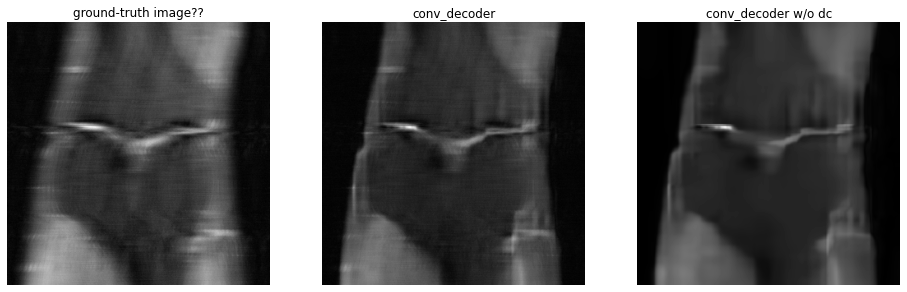

In [107]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(131)
ax1.imshow(img_gt, cmap='gray')
ax1.set_title('ground-truth image??')
ax1.axis('off')

ax2 = fig.add_subplot(132)
ax2.imshow(img_dc, cmap='gray')
ax2.set_title('conv_decoder')
ax2.axis('off')

ax2 = fig.add_subplot(133)
ax2.imshow(img_est, cmap='gray')
ax2.set_title('conv_decoder w/o dc')
ax2.axis('off')

plt.show()

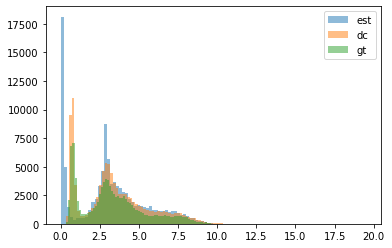

In [108]:
# est is output image without data consistency step
plt.hist(img_est.flatten(), bins=100, alpha=0.5, label='est')
plt.hist(img_dc.flatten(), bins=100, alpha=0.5, label='dc')
plt.hist(img_gt.flatten(), bins=100, alpha=0.5, label='gt')
plt.legend()
plt.show()